In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
import warnings
import networkx as nx


# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class PositionalEncoding(nn.Module):
    """
    Adds positional information to node embeddings.
    """
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, seq_length, d_model)
        Returns:
            Tensor of shape (batch_size, seq_length, d_model)
        """
        x = x + self.pe[:, :x.size(1)]
        return x

class TransformerModel(nn.Module):
    """
    Transformer model that predicts pheromone matrix given node coordinates.
    """
    def __init__(self, num_nodes, d_model=128, nhead=8, num_layers=8, dropout=0.1, learnable_pos=False):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.input_projection = nn.Linear(2, d_model)

        # Use learnable positional encoding if specified
        if learnable_pos:
            self.pos_encoder = nn.Parameter(torch.zeros(1, num_nodes, d_model))
            nn.init.uniform_(self.pos_encoder, -0.02, 0.02)
        else:
            self.pos_encoder = PositionalEncoding(d_model)

        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=512, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.output_projection = nn.Linear(d_model, d_model)
        self.final_activation = nn.ReLU()

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, num_nodes, 2)  # Node coordinates
        Returns:
            pheromone_matrix: Tensor of shape (batch_size, num_nodes, num_nodes)
        """
        x = self.input_projection(x)
        x = x * np.sqrt(self.d_model)

        # Apply positional encoding
        if isinstance(self.pos_encoder, nn.Parameter):
            x = x + self.pos_encoder[:, :x.size(1)]
        else:
            x = self.pos_encoder(x)

        x = self.transformer_encoder(x)
        x = self.output_projection(x)
        pheromone_matrix = torch.matmul(x, x.transpose(1, 2))
        pheromone_matrix = self.final_activation(pheromone_matrix)
        return pheromone_matrix



In [10]:
class StandardAntColonyOptimizer:
    """
    Implements the standard Ant Colony Optimization algorithm for TSP.
    Used for generating synthetic data and serving as a baseline.
    """
    def __init__(self, num_nodes, distance_matrix, num_ants=10, alpha=1.0, beta=2.0, evaporation_rate=0.5, Q=100):
        self.num_nodes = num_nodes
        self.distance_matrix = distance_matrix
        self.num_ants = num_ants
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.Q = Q
        self.pheromone = np.ones((num_nodes, num_nodes))
        self.best_distance = float('inf')
        self.best_solution = None

    def optimize(self, iterations=50):
        """
        Runs the ACO algorithm for a specified number of iterations.
        """
        for iteration in range(iterations):
            all_solutions = []
            all_distances = []
            for _ in range(self.num_ants):
                solution = self.construct_solution()
                distance = self.calculate_total_distance(solution)
                all_solutions.append(solution)
                all_distances.append(distance)
                if distance < self.best_distance:
                    self.best_distance = distance
                    self.best_solution = solution
            self.update_pheromone(all_solutions, all_distances)
        return self.best_solution, self.best_distance

    def construct_solution(self):
        """
        Constructs a solution (tour) by probabilistically selecting the next node based on pheromone and heuristic.
        """
        solution = []
        visited = set()
        current_node = np.random.randint(0, self.num_nodes)
        solution.append(current_node)
        visited.add(current_node)

        for _ in range(self.num_nodes - 1):
            probabilities = self.calculate_transition_probabilities(current_node, visited)
            next_node = np.random.choice(range(self.num_nodes), p=probabilities)
            solution.append(next_node)
            visited.add(next_node)
            current_node = next_node
        return solution

    def calculate_transition_probabilities(self, current_node, visited):
        """
        Calculates the probability of moving to each node not yet visited.
        """
        pheromone = self.pheromone[current_node] ** self.alpha
        heuristic = (1.0 / (self.distance_matrix[current_node] + 1e-10)) ** self.beta
        pheromone[list(visited)] = 0
        heuristic[list(visited)] = 0

        numerator = pheromone * heuristic
        denominator = np.sum(numerator)
        if denominator == 0:
            probabilities = np.ones(self.num_nodes) / self.num_nodes
        else:
            probabilities = numerator / denominator
        return probabilities

    def update_pheromone(self, solutions, distances):
        """
        Updates pheromone levels based on the solutions found by ants.
        """
        self.pheromone *= (1 - self.evaporation_rate)

        for solution, distance in zip(solutions, distances):
            pheromone_increment = self.Q / distance
            for i in range(len(solution) - 1):
                from_node = solution[i]
                to_node = solution[i + 1]
                self.pheromone[from_node][to_node] += pheromone_increment
            from_node = solution[-1]
            to_node = solution[0]
            self.pheromone[from_node][to_node] += pheromone_increment

    def calculate_total_distance(self, solution):
        """
        Calculates the total distance of the tour.
        """
        distance = 0.0
        for i in range(len(solution) - 1):
            distance += self.distance_matrix[solution[i]][solution[i + 1]]
        distance += self.distance_matrix[solution[-1]][solution[0]]
        return distance

class TransformerAntColonyOptimizer:
    """
    Enhanced ACO algorithm where the initial pheromone matrix is predicted by the Transformer model.
    """
    def __init__(self, num_nodes, distance_matrix, initial_pheromone=None, num_ants=10, alpha=1.0, beta=2.0, evaporation_rate=0.5, Q=100):
        self.num_nodes = num_nodes
        self.distance_matrix = distance_matrix
        self.num_ants = num_ants
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.Q = Q
        if initial_pheromone is not None:
            self.pheromone = initial_pheromone  # Use the provided initial pheromone matrix
        else:
            self.pheromone = np.ones((num_nodes, num_nodes))  # Initialize pheromone levels uniformly
        self.best_distance = float('inf')
        self.best_solution = None

    def optimize(self, iterations=50):
        """
        Runs the TransformerACO algorithm for a specified number of iterations.
        """
        for iteration in range(iterations):
            all_solutions = []
            all_distances = []
            for _ in range(self.num_ants):
                solution = self.construct_solution()
                distance = self.calculate_total_distance(solution)
                all_solutions.append(solution)
                all_distances.append(distance)
                if distance < self.best_distance:
                    self.best_distance = distance
                    self.best_solution = solution
            self.update_pheromone(all_solutions, all_distances)
        return self.best_solution, self.best_distance

    def construct_solution(self):
        """
        Constructs a solution (tour) by probabilistically selecting the next node based on pheromone and heuristic.
        """
        solution = []
        visited = set()
        current_node = np.random.randint(0, self.num_nodes)
        solution.append(current_node)
        visited.add(current_node)

        for _ in range(self.num_nodes - 1):
            probabilities = self.calculate_transition_probabilities(current_node, visited)
            next_node = np.random.choice(range(self.num_nodes), p=probabilities)
            solution.append(next_node)
            visited.add(next_node)
            current_node = next_node
        return solution

    def calculate_transition_probabilities(self, current_node, visited):
        """
        Calculates the probability of moving to each node not yet visited.
        """
        pheromone = self.pheromone[current_node] ** self.alpha
        heuristic = (1.0 / (self.distance_matrix[current_node] + 1e-10)) ** self.beta
        pheromone[list(visited)] = 0
        heuristic[list(visited)] = 0

        numerator = pheromone * heuristic
        denominator = np.sum(numerator)
        if denominator == 0:
            probabilities = np.ones(self.num_nodes) / self.num_nodes
        else:
            probabilities = numerator / denominator
        return probabilities

    def update_pheromone(self, solutions, distances):
        """
        Updates pheromone levels based on the solutions found by ants.
        """
        self.pheromone *= (1 - self.evaporation_rate)

        for solution, distance in zip(solutions, distances):
            pheromone_increment = self.Q / distance
            for i in range(len(solution) - 1):
                from_node = solution[i]
                to_node = solution[i + 1]
                self.pheromone[from_node][to_node] += pheromone_increment
            from_node = solution[-1]
            to_node = solution[0]
            self.pheromone[from_node][to_node] += pheromone_increment

    def calculate_total_distance(self, solution):
        """
        Calculates the total distance of the tour.
        """
        distance = 0.0
        for i in range(len(solution) - 1):
            distance += self.distance_matrix[solution[i]][solution[i + 1]]
        distance += self.distance_matrix[solution[-1]][solution[0]]
        return distance

In [11]:
import numpy as np
from tqdm import tqdm
from scipy.spatial.distance import cdist
from joblib import Parallel, delayed

def generate_tsp_solutions(num_nodes, num_samples=100, num_ants=50, iterations=100, n_jobs=-1):
    """
    Generates TSP solutions and pheromone matrices for randomly generated node coordinates.
    Utilizes parallel processing to speed up computation.

    Parameters:
    - num_nodes: Number of nodes in the TSP problem.
    - num_samples: Number of random TSP instances to generate.
    - num_ants: Number of ants in the ACO algorithm.
    - iterations: Number of iterations for the ACO algorithm.
    - n_jobs: Number of parallel jobs. -1 means using all processors.

    Returns:
    - coordinates_list: Array of node coordinates for each sample.
    - pheromone_matrices: Array of pheromone matrices for each sample.
    """
    def process_sample(_):
        # Generate random coordinates for nodes
        coordinates = np.random.rand(num_nodes, 2)

        # Compute Euclidean distance matrix using scipy for efficiency
        distance_matrix = cdist(coordinates, coordinates, metric='euclidean')

        try:
            # Initialize and run the ACO optimizer
            standard_aco = StandardAntColonyOptimizer(
                num_nodes=num_nodes,
                distance_matrix=distance_matrix,
                num_ants=num_ants,
                alpha=1.0,
                beta=2.0,
                evaporation_rate=0.3,
                Q=100
            )
            standard_aco.optimize(iterations=iterations)

            # Get and normalize the pheromone matrix
            pheromone_matrix = standard_aco.pheromone.copy()
            pheromone_matrix -= pheromone_matrix.min()
            max_val = pheromone_matrix.max()
            pheromone_matrix /= max_val if max_val > 0 else 1

            return coordinates, pheromone_matrix
        except Exception as e:
            print(f"Error processing sample: {e}")
            return None, None

    # Use parallel processing to handle multiple samples concurrently
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_sample)(i) for i in tqdm(range(num_samples), desc="Generating TSP Solutions")
    )

    # Filter out any None results from failed samples
    results = [res for res in results if res[0] is not None]

    # Unpack the results
    coordinates_list, pheromone_matrices = zip(*results)

    return np.array(coordinates_list), np.array(pheromone_matrices)

# Example usage:
# coordinates, pheromones = generate_tsp_solutions(num_nodes=50, num_samples=100, n_jobs=-1)


In [12]:
def run_experiment(node_sizes, num_trials=50, iterations=100, num_ants=50, alpha=1.0, beta=2.0, evaporation_rate=0.3, Q=100):
    """
    Runs experiments comparing StandardACO and TransformerACO across multiple node sizes.
    Prints comparisons for each trial and plots the results.
    """
    results = {}

    for num_nodes in node_sizes:
        print(f"\n=== Node Size: {num_nodes} ===")

        print("Generating synthetic data for training...")
        coordinates_list, pheromone_matrices = generate_tsp_solutions(
            num_nodes=num_nodes,
            num_samples=500
        )

        split_index = int(0.8 * len(coordinates_list))
        train_coords = coordinates_list[:split_index]
        val_coords = coordinates_list[split_index:]
        train_pheromones = pheromone_matrices[:split_index]
        val_pheromones = pheromone_matrices[split_index:]

        train_coords_tensor = torch.tensor(train_coords, dtype=torch.float).to(device)
        train_pheromone_tensors = torch.tensor(train_pheromones, dtype=torch.float).to(device)
        val_coords_tensor = torch.tensor(val_coords, dtype=torch.float).to(device)
        val_pheromone_tensors = torch.tensor(val_pheromones, dtype=torch.float).to(device)

        model = TransformerModel(num_nodes=num_nodes, d_model=128, nhead=8, num_layers=6, dropout=0.1, learnable_pos=True).to(device)
        criterion = nn.MSELoss()
        optimizer_model = optim.Adam(model.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_model, 'min', patience=5, factor=0.5)

        print("Training Transformer Model...")
        epochs = 50
        batch_size = 32
        num_samples = train_coords_tensor.size(0)
        best_val_loss = float('inf')
        patience = 10
        patience_counter = 0

        for epoch in range(epochs):
            # Training
            model.train()
            permutation = torch.randperm(num_samples)
            train_loss = 0.0
            for i in range(0, num_samples, batch_size):
                indices = permutation[i:i+batch_size]
                input_batch = train_coords_tensor[indices]
                target_batch = train_pheromone_tensors[indices]

                optimizer_model.zero_grad()
                output = model(input_batch)
                loss = criterion(output, target_batch)
                loss.backward()
                optimizer_model.step()

                train_loss += loss.item()

            avg_train_loss = train_loss / (num_samples / batch_size)

            model.eval()
            with torch.no_grad():
                val_output = model(val_coords_tensor)
                val_loss = criterion(val_output, val_pheromone_tensors).item()

            scheduler.step(val_loss)

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save the best model
                torch.save(model.state_dict(), f'best_model_{num_nodes}.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break

        model.load_state_dict(torch.load(f'best_model_{num_nodes}.pth'))

        results[num_nodes] = {'StandardACO': [], 'TransformerACO': []}

        print(f"Running {num_trials} trials for node size {num_nodes}...")
        for trial in tqdm(range(num_trials), desc=f"Trials for node size {num_nodes}"):
            trial_number = trial + 1
            coordinates = np.random.rand(num_nodes, 2)
            distance_matrix = np.sqrt(
                (coordinates[:, np.newaxis, 0] - coordinates[np.newaxis, :, 0]) ** 2 +
                (coordinates[:, np.newaxis, 1] - coordinates[np.newaxis, :, 1]) ** 2
            )

            coordinates_input = torch.tensor(coordinates[np.newaxis, :, :], dtype=torch.float).to(device)
            with torch.no_grad():
                model.eval()
                predicted_pheromone = model(coordinates_input)
            predicted_pheromone_np = predicted_pheromone.cpu().numpy()[0]

            predicted_pheromone_np -= predicted_pheromone_np.min()
            predicted_pheromone_np /= predicted_pheromone_np.max() if predicted_pheromone_np.max() > 0 else 1
            predicted_pheromone_np += 1e-6

            standard_aco = StandardAntColonyOptimizer(
                num_nodes=num_nodes,
                distance_matrix=distance_matrix,
                num_ants=num_ants,
                alpha=alpha,
                beta=beta,
                evaporation_rate=evaporation_rate,
                Q=Q
            )
            transformer_aco = TransformerAntColonyOptimizer(
                num_nodes=num_nodes,
                distance_matrix=distance_matrix,
                initial_pheromone=predicted_pheromone_np,
                num_ants=num_ants,
                alpha=alpha,
                beta=beta,
                evaporation_rate=evaporation_rate,
                Q=Q
            )

            _, best_distance_standard = standard_aco.optimize(iterations=iterations)
            _, best_distance_transformer = transformer_aco.optimize(iterations=iterations)

            results[num_nodes]['StandardACO'].append(best_distance_standard)
            results[num_nodes]['TransformerACO'].append(best_distance_transformer)

            print(f"Trial {trial_number}: StandardACO Best Distance = {best_distance_standard:.4f}, TransformerACO Best Distance = {best_distance_transformer:.4f}")

        # Plotting results for this node size
        plt.figure(figsize=(10, 6))
        plt.plot(results[num_nodes]['StandardACO'], label='StandardACO', marker='o')
        plt.plot(results[num_nodes]['TransformerACO'], label='TransformerACO', marker='s')
        plt.title(f"Best Distances for Node Size: {num_nodes}")
        plt.xlabel("Trial")
        plt.ylabel("Best Distance")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Boxplot for distribution of best distances
        plt.figure(figsize=(10, 6))
        plt.boxplot([results[num_nodes]['StandardACO'], results[num_nodes]['TransformerACO']], labels=['StandardACO', 'TransformerACO'])
        plt.title(f"Distribution of Best Distances for Node Size: {num_nodes} (Averaged Over Runs)")
        plt.ylabel("Best Distance")
        plt.grid(True)
        plt.show()

        del model

    return results


In [13]:
def perform_statistical_tests(results):
    """
    Performs Wilcoxon signed-rank tests for each node size.
    Returns a dictionary of p-values.
    """
    node_sizes = sorted(results.keys())
    p_values = {}

    for num_nodes in node_sizes:
        standard = results[num_nodes]['StandardACO']
        transformer = results[num_nodes]['TransformerACO']
        stat, p = stats.wilcoxon(standard, transformer)
        p_values[num_nodes] = p
        print(f"Node Size {num_nodes}: p-value = {p:.4e}")

    return p_values

In [14]:
def plot_results(results, p_values):
    """
    Plots average best distances for StandardACO and TransformerACO across node sizes.
    Annotates significance based on p-values.
    """
    node_sizes = sorted(results.keys())
    standard_means = [np.mean(results[size]['StandardACO']) for size in node_sizes]
    transformer_means = [np.mean(results[size]['TransformerACO']) for size in node_sizes]
    standard_stds = [np.std(results[size]['StandardACO']) for size in node_sizes]
    transformer_stds = [np.std(results[size]['TransformerACO']) for size in node_sizes]

    x = np.arange(len(node_sizes))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, standard_means, width, yerr=standard_stds, label='Standard ACO', capsize=5, color='skyblue')
    rects2 = ax.bar(x + width/2, transformer_means, width, yerr=transformer_stds, label='TransformerACO (Transformer)', capsize=5, color='salmon')

    ax.set_ylabel('Average Best Distance')
    ax.set_xlabel('Number of Nodes')
    ax.set_title('Comparison of StandardACO vs. TransformerACO Across Different Node Sizes')
    ax.set_xticks(x)
    ax.set_xticklabels(node_sizes)
    ax.legend()

    for i, size in enumerate(node_sizes):
        p = p_values[size]
        if p < 0.001:
            significance = '***'
        elif p < 0.01:
            significance = '**'
        elif p < 0.05:
            significance = '*'
        else:
            significance = 'ns'
        ax.text(x[i], max(standard_means[i], transformer_means[i]) + max(standard_stds[i], transformer_stds[i]) + 0.05, significance, ha='center', va='bottom', color='black', fontsize=12)

    plt.tight_layout()
    plt.show()


=== Node Size: 30 ===
Generating synthetic data for training...



Generating TSP Solutions: 100%|██████████| 500/500 [09:28<00:00,  1.14s/it]


Training Transformer Model...
Epoch 1/50, Train Loss: 187.6751, Val Loss: 10.7103
Epoch 2/50, Train Loss: 4.8546, Val Loss: 1.1502
Epoch 3/50, Train Loss: 0.8107, Val Loss: 0.1855
Epoch 4/50, Train Loss: 0.3596, Val Loss: 0.0424
Epoch 5/50, Train Loss: 0.2526, Val Loss: 0.0222
Epoch 6/50, Train Loss: 0.2197, Val Loss: 0.0188
Epoch 7/50, Train Loss: 0.2041, Val Loss: 0.0184
Epoch 8/50, Train Loss: 0.1890, Val Loss: 0.0186
Epoch 9/50, Train Loss: 0.1820, Val Loss: 0.0186
Epoch 10/50, Train Loss: 0.1706, Val Loss: 0.0187
Epoch 11/50, Train Loss: 0.1624, Val Loss: 0.0188
Epoch 12/50, Train Loss: 0.1492, Val Loss: 0.0187
Epoch 13/50, Train Loss: 0.1401, Val Loss: 0.0186
Epoch 14/50, Train Loss: 0.1327, Val Loss: 0.0188
Epoch 15/50, Train Loss: 0.1280, Val Loss: 0.0187
Epoch 16/50, Train Loss: 0.1245, Val Loss: 0.0189
Epoch 17/50, Train Loss: 0.1210, Val Loss: 0.0188
Early stopping triggered.


<ipython-input-12-713046c0cc32>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{num_nodes}.pth'))


Running 30 trials for node size 30...



Trials for node size 30:   3%|▎         | 1/30 [00:03<01:31,  3.14s/it]

Trial 1: StandardACO Best Distance = 4.7747, TransformerACO Best Distance = 4.7548



Trials for node size 30:   7%|▋         | 2/30 [00:06<01:26,  3.10s/it]

Trial 2: StandardACO Best Distance = 4.4897, TransformerACO Best Distance = 4.3827



Trials for node size 30:  10%|█         | 3/30 [00:09<01:23,  3.11s/it]

Trial 3: StandardACO Best Distance = 4.9708, TransformerACO Best Distance = 4.7815



Trials for node size 30:  13%|█▎        | 4/30 [00:12<01:21,  3.14s/it]

Trial 4: StandardACO Best Distance = 4.2786, TransformerACO Best Distance = 4.3945



Trials for node size 30:  17%|█▋        | 5/30 [00:15<01:20,  3.21s/it]

Trial 5: StandardACO Best Distance = 4.5534, TransformerACO Best Distance = 4.5887



Trials for node size 30:  20%|██        | 6/30 [00:18<01:16,  3.18s/it]

Trial 6: StandardACO Best Distance = 4.0325, TransformerACO Best Distance = 4.0342



Trials for node size 30:  23%|██▎       | 7/30 [00:22<01:12,  3.17s/it]

Trial 7: StandardACO Best Distance = 4.9780, TransformerACO Best Distance = 4.9078



Trials for node size 30:  27%|██▋       | 8/30 [00:25<01:09,  3.14s/it]

Trial 8: StandardACO Best Distance = 4.6697, TransformerACO Best Distance = 4.6200



Trials for node size 30:  30%|███       | 9/30 [00:28<01:07,  3.22s/it]

Trial 9: StandardACO Best Distance = 4.7312, TransformerACO Best Distance = 4.7390



Trials for node size 30:  33%|███▎      | 10/30 [00:31<01:04,  3.20s/it]

Trial 10: StandardACO Best Distance = 4.6558, TransformerACO Best Distance = 4.6874



Trials for node size 30:  37%|███▋      | 11/30 [00:34<01:00,  3.19s/it]

Trial 11: StandardACO Best Distance = 4.4644, TransformerACO Best Distance = 4.5991



Trials for node size 30:  40%|████      | 12/30 [00:38<00:57,  3.20s/it]

Trial 12: StandardACO Best Distance = 4.8491, TransformerACO Best Distance = 4.7943



Trials for node size 30:  43%|████▎     | 13/30 [00:41<00:55,  3.24s/it]

Trial 13: StandardACO Best Distance = 4.9458, TransformerACO Best Distance = 5.1097



Trials for node size 30:  47%|████▋     | 14/30 [00:44<00:51,  3.21s/it]

Trial 14: StandardACO Best Distance = 4.4540, TransformerACO Best Distance = 4.4540



Trials for node size 30:  50%|█████     | 15/30 [00:47<00:47,  3.17s/it]

Trial 15: StandardACO Best Distance = 4.8655, TransformerACO Best Distance = 4.7877



Trials for node size 30:  53%|█████▎    | 16/30 [00:51<00:45,  3.21s/it]

Trial 16: StandardACO Best Distance = 4.5284, TransformerACO Best Distance = 4.7202



Trials for node size 30:  57%|█████▋    | 17/30 [00:54<00:41,  3.18s/it]

Trial 17: StandardACO Best Distance = 4.8638, TransformerACO Best Distance = 4.8867



Trials for node size 30:  60%|██████    | 18/30 [00:57<00:37,  3.16s/it]

Trial 18: StandardACO Best Distance = 4.1884, TransformerACO Best Distance = 4.0855



Trials for node size 30:  63%|██████▎   | 19/30 [01:00<00:34,  3.14s/it]

Trial 19: StandardACO Best Distance = 4.7138, TransformerACO Best Distance = 4.7842



Trials for node size 30:  67%|██████▋   | 20/30 [01:03<00:31,  3.15s/it]

Trial 20: StandardACO Best Distance = 4.9882, TransformerACO Best Distance = 4.9247



Trials for node size 30:  70%|███████   | 21/30 [01:06<00:28,  3.16s/it]

Trial 21: StandardACO Best Distance = 4.7471, TransformerACO Best Distance = 4.8819



Trials for node size 30:  73%|███████▎  | 22/30 [01:09<00:25,  3.17s/it]

Trial 22: StandardACO Best Distance = 4.0347, TransformerACO Best Distance = 3.9797



Trials for node size 30:  77%|███████▋  | 23/30 [01:12<00:22,  3.15s/it]

Trial 23: StandardACO Best Distance = 5.0488, TransformerACO Best Distance = 5.0522



Trials for node size 30:  80%|████████  | 24/30 [01:16<00:19,  3.19s/it]

Trial 24: StandardACO Best Distance = 4.8100, TransformerACO Best Distance = 4.6557



Trials for node size 30:  83%|████████▎ | 25/30 [01:19<00:16,  3.25s/it]

Trial 25: StandardACO Best Distance = 4.6183, TransformerACO Best Distance = 4.8055



Trials for node size 30:  87%|████████▋ | 26/30 [01:22<00:12,  3.21s/it]

Trial 26: StandardACO Best Distance = 4.4037, TransformerACO Best Distance = 4.4079



Trials for node size 30:  90%|█████████ | 27/30 [01:25<00:09,  3.19s/it]

Trial 27: StandardACO Best Distance = 4.6021, TransformerACO Best Distance = 4.5694



Trials for node size 30:  93%|█████████▎| 28/30 [01:28<00:06,  3.15s/it]

Trial 28: StandardACO Best Distance = 4.8732, TransformerACO Best Distance = 4.6920



Trials for node size 30:  97%|█████████▋| 29/30 [01:32<00:03,  3.14s/it]

Trial 29: StandardACO Best Distance = 4.9415, TransformerACO Best Distance = 4.6987



Trials for node size 30: 100%|██████████| 30/30 [01:35<00:00,  3.18s/it]

Trial 30: StandardACO Best Distance = 4.8535, TransformerACO Best Distance = 4.8682


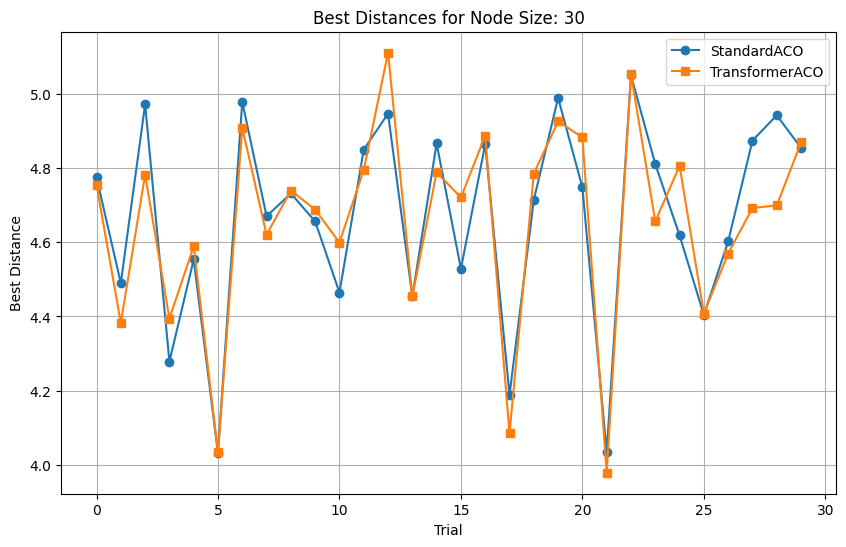

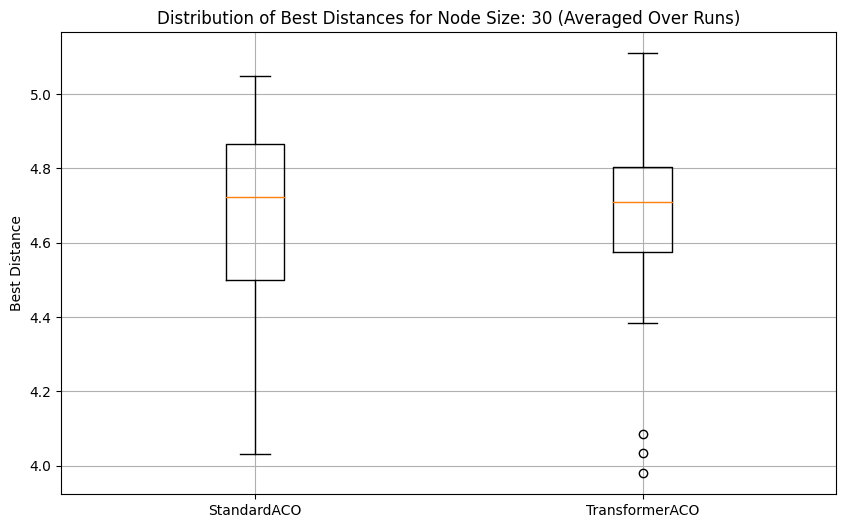


=== Node Size: 35 ===
Generating synthetic data for training...



Generating TSP Solutions: 100%|██████████| 500/500 [11:13<00:00,  1.35s/it]


Training Transformer Model...
Epoch 1/50, Train Loss: 256.4975, Val Loss: 9.7385
Epoch 2/50, Train Loss: 4.9814, Val Loss: 1.7252
Epoch 3/50, Train Loss: 1.0450, Val Loss: 0.2919
Epoch 4/50, Train Loss: 0.3956, Val Loss: 0.0549
Epoch 5/50, Train Loss: 0.2458, Val Loss: 0.0242
Epoch 6/50, Train Loss: 0.2110, Val Loss: 0.0176
Epoch 7/50, Train Loss: 0.1903, Val Loss: 0.0162
Epoch 8/50, Train Loss: 0.1739, Val Loss: 0.0159
Epoch 9/50, Train Loss: 0.1587, Val Loss: 0.0160
Epoch 10/50, Train Loss: 0.1486, Val Loss: 0.0160
Epoch 11/50, Train Loss: 0.1376, Val Loss: 0.0161
Epoch 12/50, Train Loss: 0.1314, Val Loss: 0.0162
Epoch 13/50, Train Loss: 0.1240, Val Loss: 0.0161
Epoch 14/50, Train Loss: 0.1193, Val Loss: 0.0161
Epoch 15/50, Train Loss: 0.1161, Val Loss: 0.0162
Epoch 16/50, Train Loss: 0.1141, Val Loss: 0.0162
Epoch 17/50, Train Loss: 0.1125, Val Loss: 0.0162
Epoch 18/50, Train Loss: 0.1116, Val Loss: 0.0163
Early stopping triggered.


<ipython-input-12-713046c0cc32>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{num_nodes}.pth'))


Running 30 trials for node size 35...



Trials for node size 35:   3%|▎         | 1/30 [00:03<01:48,  3.74s/it]

Trial 1: StandardACO Best Distance = 5.1323, TransformerACO Best Distance = 5.1173



Trials for node size 35:   7%|▋         | 2/30 [00:07<01:44,  3.72s/it]

Trial 2: StandardACO Best Distance = 4.8342, TransformerACO Best Distance = 4.7593



Trials for node size 35:  10%|█         | 3/30 [00:11<01:40,  3.72s/it]

Trial 3: StandardACO Best Distance = 5.1727, TransformerACO Best Distance = 4.9177



Trials for node size 35:  13%|█▎        | 4/30 [00:14<01:36,  3.71s/it]

Trial 4: StandardACO Best Distance = 4.8693, TransformerACO Best Distance = 5.0364



Trials for node size 35:  17%|█▋        | 5/30 [00:18<01:32,  3.70s/it]

Trial 5: StandardACO Best Distance = 4.9817, TransformerACO Best Distance = 4.7345



Trials for node size 35:  20%|██        | 6/30 [00:22<01:28,  3.70s/it]

Trial 6: StandardACO Best Distance = 4.6241, TransformerACO Best Distance = 4.6261



Trials for node size 35:  23%|██▎       | 7/30 [00:25<01:25,  3.70s/it]

Trial 7: StandardACO Best Distance = 4.2963, TransformerACO Best Distance = 4.5085



Trials for node size 35:  27%|██▋       | 8/30 [00:29<01:21,  3.72s/it]

Trial 8: StandardACO Best Distance = 5.3406, TransformerACO Best Distance = 5.2804



Trials for node size 35:  30%|███       | 9/30 [00:33<01:17,  3.71s/it]

Trial 9: StandardACO Best Distance = 4.5584, TransformerACO Best Distance = 4.3754



Trials for node size 35:  33%|███▎      | 10/30 [00:37<01:14,  3.72s/it]

Trial 10: StandardACO Best Distance = 5.1482, TransformerACO Best Distance = 5.0791



Trials for node size 35:  37%|███▋      | 11/30 [00:40<01:10,  3.71s/it]

Trial 11: StandardACO Best Distance = 5.2586, TransformerACO Best Distance = 5.3016



Trials for node size 35:  40%|████      | 12/30 [00:45<01:10,  3.91s/it]

Trial 12: StandardACO Best Distance = 4.4564, TransformerACO Best Distance = 4.5861



Trials for node size 35:  43%|████▎     | 13/30 [00:48<01:05,  3.83s/it]

Trial 13: StandardACO Best Distance = 5.0599, TransformerACO Best Distance = 4.9741



Trials for node size 35:  47%|████▋     | 14/30 [00:52<01:01,  3.82s/it]

Trial 14: StandardACO Best Distance = 5.2520, TransformerACO Best Distance = 5.3722



Trials for node size 35:  50%|█████     | 15/30 [00:56<00:56,  3.78s/it]

Trial 15: StandardACO Best Distance = 5.0726, TransformerACO Best Distance = 5.2585



Trials for node size 35:  53%|█████▎    | 16/30 [01:00<00:52,  3.77s/it]

Trial 16: StandardACO Best Distance = 5.3658, TransformerACO Best Distance = 5.6223



Trials for node size 35:  57%|█████▋    | 17/30 [01:03<00:49,  3.80s/it]

Trial 17: StandardACO Best Distance = 5.0588, TransformerACO Best Distance = 5.0908



Trials for node size 35:  60%|██████    | 18/30 [01:07<00:45,  3.81s/it]

Trial 18: StandardACO Best Distance = 5.3235, TransformerACO Best Distance = 5.2368



Trials for node size 35:  63%|██████▎   | 19/30 [01:11<00:41,  3.78s/it]

Trial 19: StandardACO Best Distance = 4.9039, TransformerACO Best Distance = 4.8763



Trials for node size 35:  67%|██████▋   | 20/30 [01:15<00:37,  3.74s/it]

Trial 20: StandardACO Best Distance = 5.1787, TransformerACO Best Distance = 5.0761



Trials for node size 35:  70%|███████   | 21/30 [01:19<00:35,  3.89s/it]

Trial 21: StandardACO Best Distance = 5.1934, TransformerACO Best Distance = 5.0375



Trials for node size 35:  73%|███████▎  | 22/30 [01:23<00:30,  3.85s/it]

Trial 22: StandardACO Best Distance = 5.8087, TransformerACO Best Distance = 5.9403



Trials for node size 35:  77%|███████▋  | 23/30 [01:27<00:27,  3.97s/it]

Trial 23: StandardACO Best Distance = 5.3158, TransformerACO Best Distance = 5.2672



Trials for node size 35:  80%|████████  | 24/30 [01:31<00:23,  3.89s/it]

Trial 24: StandardACO Best Distance = 5.0974, TransformerACO Best Distance = 5.3211



Trials for node size 35:  83%|████████▎ | 25/30 [01:34<00:19,  3.85s/it]

Trial 25: StandardACO Best Distance = 5.8343, TransformerACO Best Distance = 5.6623



Trials for node size 35:  87%|████████▋ | 26/30 [01:38<00:15,  3.81s/it]

Trial 26: StandardACO Best Distance = 5.1934, TransformerACO Best Distance = 5.3309



Trials for node size 35:  90%|█████████ | 27/30 [01:42<00:11,  3.77s/it]

Trial 27: StandardACO Best Distance = 4.7858, TransformerACO Best Distance = 4.9891



Trials for node size 35:  93%|█████████▎| 28/30 [01:45<00:07,  3.75s/it]

Trial 28: StandardACO Best Distance = 5.2683, TransformerACO Best Distance = 5.1918



Trials for node size 35:  97%|█████████▋| 29/30 [01:50<00:03,  3.84s/it]

Trial 29: StandardACO Best Distance = 4.8670, TransformerACO Best Distance = 4.6908



Trials for node size 35: 100%|██████████| 30/30 [01:53<00:00,  3.80s/it]

Trial 30: StandardACO Best Distance = 5.1698, TransformerACO Best Distance = 5.2613


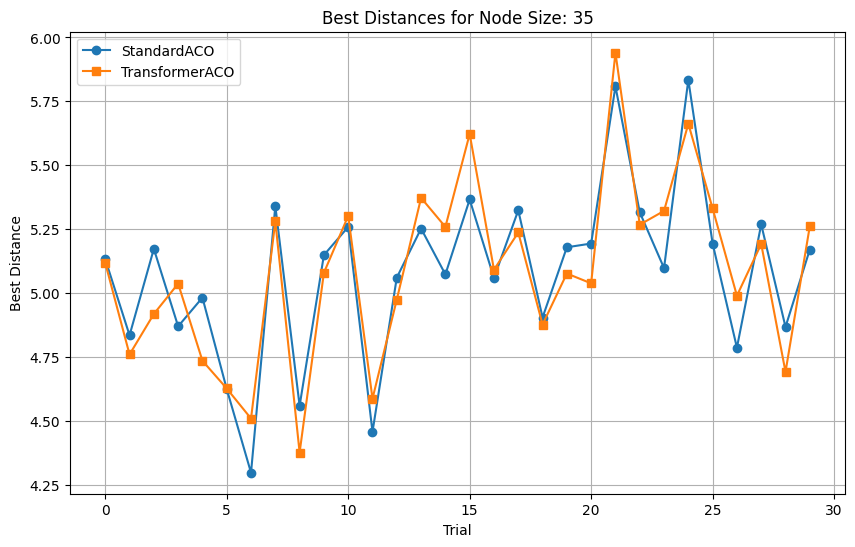

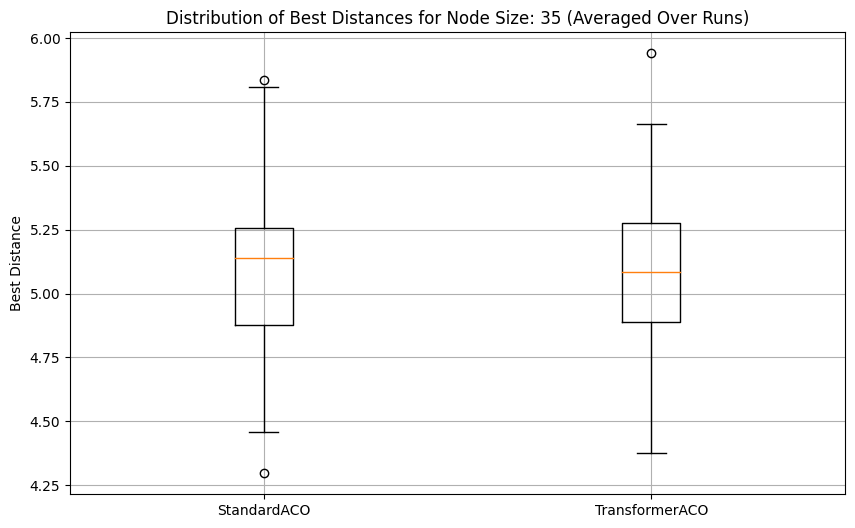


=== Node Size: 40 ===
Generating synthetic data for training...



Generating TSP Solutions: 100%|██████████| 500/500 [13:02<00:00,  1.56s/it]


Training Transformer Model...
Epoch 1/50, Train Loss: 211.2106, Val Loss: 9.7265
Epoch 2/50, Train Loss: 4.5584, Val Loss: 1.3654
Epoch 3/50, Train Loss: 1.0005, Val Loss: 0.2170
Epoch 4/50, Train Loss: 0.3570, Val Loss: 0.0449
Epoch 5/50, Train Loss: 0.2396, Val Loss: 0.0184
Epoch 6/50, Train Loss: 0.2046, Val Loss: 0.0146
Epoch 7/50, Train Loss: 0.1880, Val Loss: 0.0141
Epoch 8/50, Train Loss: 0.1724, Val Loss: 0.0141
Epoch 9/50, Train Loss: 0.1612, Val Loss: 0.0142
Epoch 10/50, Train Loss: 0.1499, Val Loss: 0.0142
Epoch 11/50, Train Loss: 0.1373, Val Loss: 0.0141
Epoch 12/50, Train Loss: 0.1297, Val Loss: 0.0141
Epoch 13/50, Train Loss: 0.1237, Val Loss: 0.0142
Epoch 14/50, Train Loss: 0.1197, Val Loss: 0.0142
Epoch 15/50, Train Loss: 0.1167, Val Loss: 0.0143
Epoch 16/50, Train Loss: 0.1155, Val Loss: 0.0141
Epoch 17/50, Train Loss: 0.1127, Val Loss: 0.0142
Early stopping triggered.


<ipython-input-12-713046c0cc32>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{num_nodes}.pth'))


Running 30 trials for node size 40...



Trials for node size 40:   3%|▎         | 1/30 [00:04<02:01,  4.20s/it]

Trial 1: StandardACO Best Distance = 5.0152, TransformerACO Best Distance = 5.0599



Trials for node size 40:   7%|▋         | 2/30 [00:08<02:00,  4.29s/it]

Trial 2: StandardACO Best Distance = 6.3136, TransformerACO Best Distance = 5.9549



Trials for node size 40:  10%|█         | 3/30 [00:12<01:55,  4.29s/it]

Trial 3: StandardACO Best Distance = 5.5533, TransformerACO Best Distance = 5.5535



Trials for node size 40:  13%|█▎        | 4/30 [00:17<01:52,  4.34s/it]

Trial 4: StandardACO Best Distance = 5.5227, TransformerACO Best Distance = 5.4676



Trials for node size 40:  17%|█▋        | 5/30 [00:21<01:48,  4.36s/it]

Trial 5: StandardACO Best Distance = 5.7281, TransformerACO Best Distance = 6.0464



Trials for node size 40:  20%|██        | 6/30 [00:25<01:43,  4.31s/it]

Trial 6: StandardACO Best Distance = 5.5366, TransformerACO Best Distance = 5.1722



Trials for node size 40:  23%|██▎       | 7/30 [00:30<01:41,  4.41s/it]

Trial 7: StandardACO Best Distance = 4.8519, TransformerACO Best Distance = 4.6312



Trials for node size 40:  27%|██▋       | 8/30 [00:34<01:36,  4.40s/it]

Trial 8: StandardACO Best Distance = 5.7330, TransformerACO Best Distance = 5.5653



Trials for node size 40:  30%|███       | 9/30 [00:39<01:31,  4.36s/it]

Trial 9: StandardACO Best Distance = 5.7099, TransformerACO Best Distance = 5.7994



Trials for node size 40:  33%|███▎      | 10/30 [00:43<01:26,  4.34s/it]

Trial 10: StandardACO Best Distance = 5.3846, TransformerACO Best Distance = 5.4447



Trials for node size 40:  37%|███▋      | 11/30 [00:47<01:22,  4.32s/it]

Trial 11: StandardACO Best Distance = 6.0806, TransformerACO Best Distance = 5.9282



Trials for node size 40:  40%|████      | 12/30 [00:51<01:17,  4.30s/it]

Trial 12: StandardACO Best Distance = 5.2829, TransformerACO Best Distance = 4.8240



Trials for node size 40:  43%|████▎     | 13/30 [00:56<01:12,  4.29s/it]

Trial 13: StandardACO Best Distance = 5.3204, TransformerACO Best Distance = 5.4360



Trials for node size 40:  47%|████▋     | 14/30 [01:00<01:09,  4.34s/it]

Trial 14: StandardACO Best Distance = 5.0393, TransformerACO Best Distance = 5.1914



Trials for node size 40:  50%|█████     | 15/30 [01:05<01:06,  4.40s/it]

Trial 15: StandardACO Best Distance = 5.4327, TransformerACO Best Distance = 5.7157



Trials for node size 40:  53%|█████▎    | 16/30 [01:09<01:01,  4.41s/it]

Trial 16: StandardACO Best Distance = 6.1021, TransformerACO Best Distance = 5.8579



Trials for node size 40:  57%|█████▋    | 17/30 [01:14<00:57,  4.44s/it]

Trial 17: StandardACO Best Distance = 5.7500, TransformerACO Best Distance = 5.7644



Trials for node size 40:  60%|██████    | 18/30 [01:18<00:54,  4.51s/it]

Trial 18: StandardACO Best Distance = 5.2602, TransformerACO Best Distance = 5.1772



Trials for node size 40:  63%|██████▎   | 19/30 [01:23<00:48,  4.45s/it]

Trial 19: StandardACO Best Distance = 5.5666, TransformerACO Best Distance = 5.1637



Trials for node size 40:  67%|██████▋   | 20/30 [01:27<00:45,  4.54s/it]

Trial 20: StandardACO Best Distance = 4.9950, TransformerACO Best Distance = 5.5703



Trials for node size 40:  70%|███████   | 21/30 [01:32<00:41,  4.60s/it]

Trial 21: StandardACO Best Distance = 5.2986, TransformerACO Best Distance = 5.3398



Trials for node size 40:  73%|███████▎  | 22/30 [01:37<00:37,  4.63s/it]

Trial 22: StandardACO Best Distance = 5.6667, TransformerACO Best Distance = 5.4762



Trials for node size 40:  77%|███████▋  | 23/30 [01:41<00:31,  4.56s/it]

Trial 23: StandardACO Best Distance = 5.3960, TransformerACO Best Distance = 5.3268



Trials for node size 40:  80%|████████  | 24/30 [01:46<00:27,  4.55s/it]

Trial 24: StandardACO Best Distance = 4.6984, TransformerACO Best Distance = 4.9283



Trials for node size 40:  83%|████████▎ | 25/30 [01:50<00:22,  4.49s/it]

Trial 25: StandardACO Best Distance = 6.2028, TransformerACO Best Distance = 5.9917



Trials for node size 40:  87%|████████▋ | 26/30 [01:54<00:17,  4.44s/it]

Trial 26: StandardACO Best Distance = 5.7014, TransformerACO Best Distance = 5.5859



Trials for node size 40:  90%|█████████ | 27/30 [01:59<00:13,  4.55s/it]

Trial 27: StandardACO Best Distance = 5.6872, TransformerACO Best Distance = 5.6382



Trials for node size 40:  93%|█████████▎| 28/30 [02:03<00:08,  4.46s/it]

Trial 28: StandardACO Best Distance = 5.2852, TransformerACO Best Distance = 5.3486



Trials for node size 40:  97%|█████████▋| 29/30 [02:08<00:04,  4.41s/it]

Trial 29: StandardACO Best Distance = 5.6231, TransformerACO Best Distance = 5.6219



Trials for node size 40: 100%|██████████| 30/30 [02:12<00:00,  4.43s/it]

Trial 30: StandardACO Best Distance = 5.4859, TransformerACO Best Distance = 5.3272


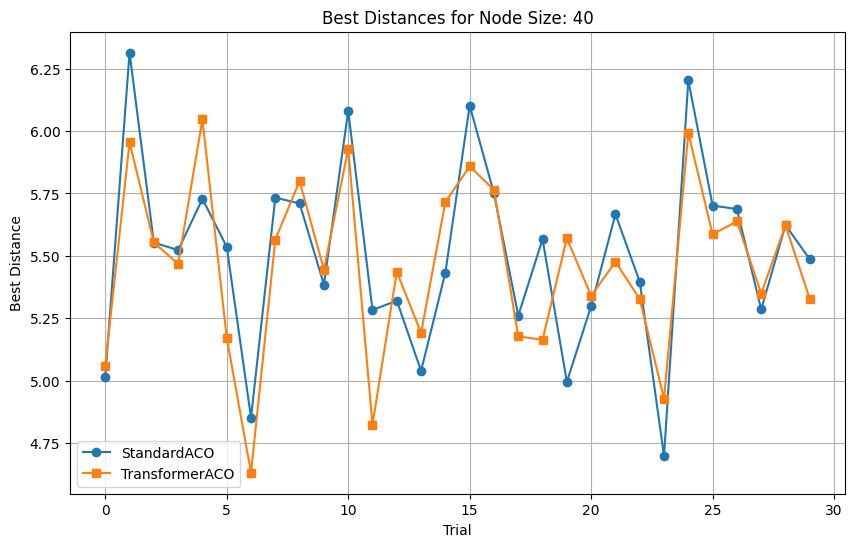

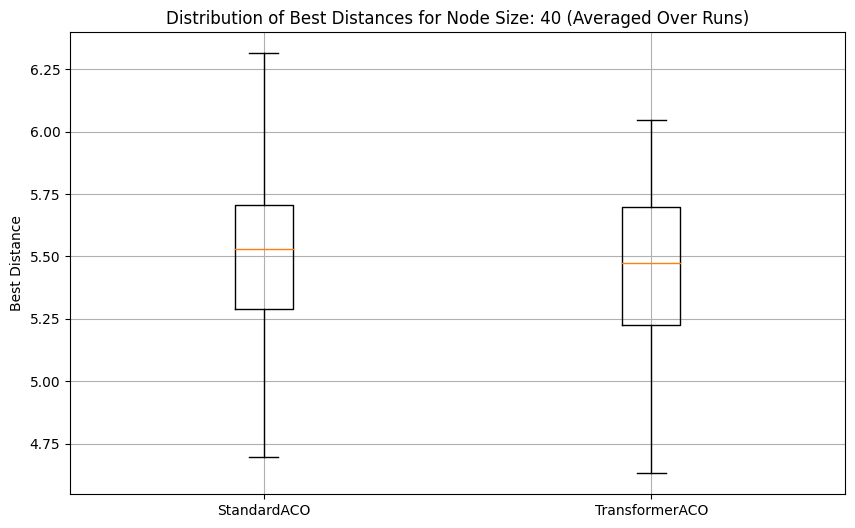


=== Statistical Significance Testing ===
Node Size 30: p-value = 6.5757e-01
Node Size 35: p-value = 8.7121e-01
Node Size 40: p-value = 2.2065e-01


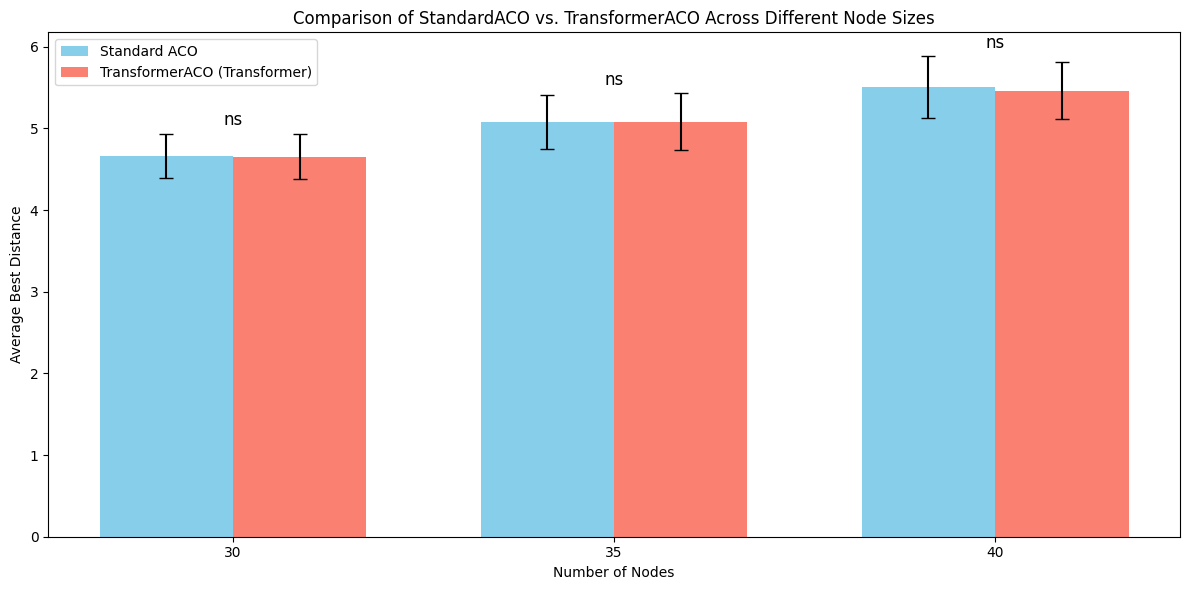

In [15]:
node_sizes = [30, 35, 40]

num_trials = 30
iterations = 50
num_ants = 20
alpha = 1.0
beta = 2.0
evaporation_rate = 0.5
Q = 100

results = run_experiment(
    node_sizes=node_sizes,
    num_trials=num_trials,
    iterations=iterations,
    num_ants=num_ants,
    alpha=alpha,
    beta=beta,
    evaporation_rate=evaporation_rate,
    Q=Q
)

print("\n=== Statistical Significance Testing ===")
p_values = perform_statistical_tests(results)

plot_results(results, p_values)
